In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [37]:
def combined_dataset():
    train = pd.read_csv("data/train.csv")
    test = pd.read_csv("data/test.csv")
    targets = train.Survived
    train.drop('Survived', 1, inplace=True)
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop('index', inplace=True, axis=1)
    
    return combined, train.shape[0]

In [38]:
combined, idx = combined_dataset()

### Fare

In [39]:
combined.Fare.isnull().sum()
combined[combined.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [40]:
# the only null value is or a passenger with pclass=3 and embarked=S
# I can use the median for this subset. 
def process_fare(idx):
    global combined
    median = combined.Fare[(combined.Pclass == 3) & (combined.Embarked == 'S')].median()
    combined.Fare.fillna(median, inplace=True)

process_fare(idx)

In [41]:
combined.Fare.isnull().sum()

0

### Title

In [42]:
def process_title():
    global combined
    combined['Title'] = combined[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )
    title_map = {
        "Capt":       "Officer",
        "Col":        "Officer",
        "Major":      "Officer",
        "Jonkheer":   "Royalty",
        "Don":        "Royalty",
        "Sir" :       "Royalty",
        "Dr":         "Officer",
        "Rev":        "Officer",
        "the Countess":"Royalty",
        "Dona":       "Royalty",
        "Mme":        "Mrs",
        "Mlle":       "Miss",
        "Ms":         "Mrs",
        "Mr" :        "Mr",
        "Mrs" :       "Mrs",
        "Miss" :      "Miss",
        "Master" :    "Master",
        "Lady" :      "Royalty"
    }

    combined['Title'] = combined.Title.map(title_map)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(combined['Title'],prefix='Title')
    combined = pd.concat([combined,titles_dummies],axis=1)
    
    # combined.drop('Title',axis=1,inplace=True)
    combined.drop('Name',axis=1,inplace=True)

process_title()

In [43]:
combined.Age.isnull().sum()

263

### Cabin

In [44]:
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return 'None'

def process_cabin():
    global combined
    combined['Cabin'] = combined.Cabin.apply(clean_cabin)
    #print(combined['Cabin'])
    cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')
    combined = pd.concat([combined,cabin_dummies], axis=1)
    combined.drop('Cabin', axis=1, inplace=True)
    
process_cabin()

### Embarked

In [45]:
def process_embarked():
    global combined
    # 2 missing values for embarked, they have pclass=1 and Fare = 80
    # the boxplot below shows that for class1 and embarked C the mean value of a fare is 80, so we can assume the missing
    # embarked is C
    combined.Embarked.fillna('C', inplace=True)

    embarked_dummies = pd.get_dummies(combined['Embarked'],prefix='Embarked')
    combined = pd.concat([combined,embarked_dummies],axis=1)
    combined.drop('Embarked',axis=1,inplace=True)

process_embarked()

### Sex

In [46]:
def process_sex():
    global combined
    
    combined['Sex'] = combined['Sex'].map({'male':1,'female':0})

process_sex()

### Pclass

In [47]:
def process_pclass():
    global combined
    
    pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")
    combined = pd.concat([combined,pclass_dummies],axis=1)
    combined.drop('Pclass',axis=1,inplace=True)
    
process_pclass()

### Ticket

In [48]:
def clean_ticket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))

    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

def process_ticket():
    global combined
    
    combined['Ticket'] = combined.Ticket.apply(clean_ticket)
    
    ticket_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
    combined = pd.concat([combined,ticket_dummies], axis=1)
    combined.drop('Ticket', axis=1, inplace=True)
    
process_ticket()

### Child

In [49]:
def process_child():
    global combined 
    
    combined['Child'] = np.where(combined['Age'] < 18, 1, 0)
    
process_child()

In [50]:
def process_adult():
    global combined 
    
    combined['Adult'] = np.where(combined['Age'] >= 18, 1, 0)
    
process_adult()

In [51]:
def process_mother():
    global combined
    
    combined['Mother'] = np.where( (combined['Age'] >= 18) & (combined['Sex'] == 0) & (combined['Title'] != 'Miss') & (combined['Parch'] > 0), 1, 0)
    combined.drop('Title', inplace=True, axis=1)
process_mother()


### Family

In [52]:
def process_family():
    global combined

    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    combined['Family_Single'] = combined[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
    combined['Family_Small']  = combined[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
    combined['Family_Large']  = combined[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )

process_family()

In [53]:
combined.Age.isnull().sum()

263

In [54]:
age_df = combined[['Age', 'Sex', 'SibSp', 'Parch', 'Fare', 
                   'Embarked_C', 'Embarked_Q','Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Child']]


knownAge = age_df.loc[ (combined.Age.notnull()) ]
unknownAge = age_df.loc[ (combined.Age.isnull()) ]

y = knownAge.values[:, 0]    
X = knownAge.values[:, 1::]

rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
rtr.fit(X, y)
predictedAges = rtr.predict(unknownAge.values[:, 1::])
combined.loc[ (combined.Age.isnull()), 'Age' ] = predictedAges 
combined.Age.isnull().sum()

0

In [55]:
combined.head()

,PassengerId,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Ticket_WC,Ticket_WEP,Ticket_XXX,Child,Adult,Mother,FamilySize,Family_Single,Family_Small,Family_Large
0,1,1,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0,1,0,2,0,1,0
1,2,0,38.0,1,0,71.2833,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0,1,0,2,0,1,0
2,3,0,26.0,0,0,7.9250,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0,1,0,1,1,0,0
3,4,0,35.0,1,0,53.1000,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0,1,0,2,0,1,0
4,5,1,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0,1,0,1,1,0,0


### Modeling

In [56]:
def get_original_datasets(idx):
    global combined
    
    train0 = pd.read_csv('data/train.csv')
    
    targets = train0.Survived
    train = combined.head(idx)
    test = combined.iloc[idx:]
    
    return train, test, targets

In [57]:
train, test, targets = get_original_datasets(idx)

In [58]:
passengerIds = test['PassengerId']
train.drop('PassengerId', inplace=True, axis=1)
test.drop('PassengerId', inplace=True, axis=1)

columns = train.columns

### Feature selection

In [59]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)
features.set_index('feature', inplace=True)


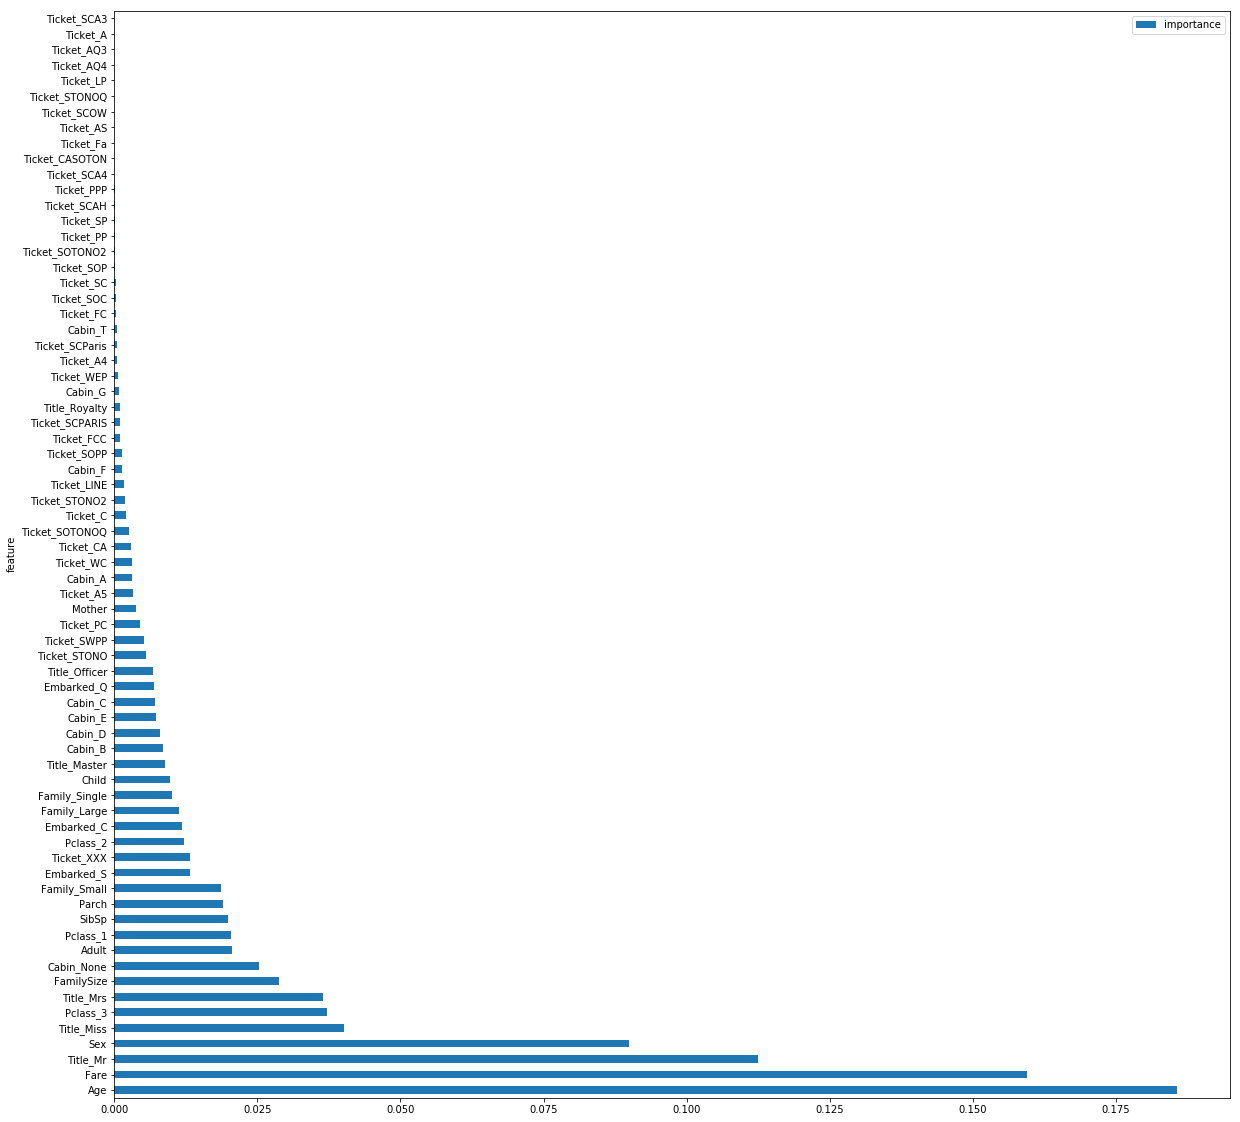

In [60]:
features.plot(kind='barh', figsize=(20, 20))


In [61]:
from sklearn.feature_selection import SelectFromModel

select_model = True

if select_model:
    sfm = SelectFromModel(clf, prefit=True)
    train = sfm.transform(train)
    test = sfm.transform(test)
    print(columns[sfm.get_support()]) 
else:
    num_features = 12
    features.head(num_features).index
    train = train.loc[:, features.head(num_features).index]
    test = test.loc[:, features.head(num_features).index]

Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Cabin_None', 'Pclass_1', 'Pclass_3', 'Adult',
       'FamilySize', 'Family_Small'],
      dtype='object')


In [62]:
X_train, X_test, y_train, y_test = train_test_split(train, targets, test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(623, 14)
(268, 14)
(623,)
(268,)


### Gridsearchcv

* n_estimators: @Falcon is wrong, in general the more trees the less likely the algorithm is to overfit. So try increasing this. The lower this number, the closer the model is to a decision tree, with a restricted feature set.
* max_features: try reducing this number (try 30-50% of the number of features). This determines how many features each tree is randomly assigned. The smaller, the less likely to overfit, but too small will start to introduce under fitting.
* max_depth: Experiment with this. This will reduce the complexity of the learned models, lowering over fitting risk. Try starting small, say 5-10, and increasing you get the best result.
* min_samples_leaf: Try setting this to values greater than one. This has a similar effect to the max_depth parameter, it means the branch will stop splitting once the leaves have that number of samples each.

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

gs = False

if gs:
    param_grid = {
     'max_depth' : [4, 6, 8],
     'n_estimators': [10, 100, 200, 500],
     'max_features': ['sqrt', 'log2', 0.3],
     'min_samples_leaf': [1,5,10,50,100,200],
     'max_depth': [5, 10, 20]
    }

    cv = StratifiedKFold(targets, n_folds=5)
    gs = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=cv)
    gs = gs.fit(train, targets)
    print(gs.best_params_)

{'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'n_estimators': 10}


In [64]:
# model = RandomForestClassifier(n_estimators=10, max_depth=4, max_features='auto', min_samples_leaf=1,oob_score=True, random_state=42)

# Params suggested by GridSearchCV
# model = RandomForestClassifier(n_estimators=10, max_depth=10, max_features='sqrt', min_samples_leaf=5,oob_score=True, random_state=42)

model = RandomForestClassifier(n_estimators=10, max_depth=50, max_features=0.3, min_samples_leaf=5,oob_score=True, random_state=42)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)



In [65]:
model.score(X_test, y_test)

0.83582089552238803

In [66]:
def cstats(y_test, y_test_pred):
    return roc_auc_score(y_test, y_test_pred)


In [67]:
print('training set:', cstats(y_train, y_train_pred))
print('validation set:', cstats(y_test, y_test_pred))

training set: 0.836299646428
validation set: 0.818452380952


In [68]:
kfold = KFold(n_splits=10, random_state=7)
scores = cross_val_score(model, X_train, y_train, cv=kfold)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.82 (+/- 0.06)


In [69]:
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.86      0.89      0.87       168
          1       0.80      0.75      0.77       100

avg / total       0.83      0.84      0.83       268



In [70]:
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('data/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('submissions/sn_submission.csv',index=False)